In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Default Pooling + Sigmoid

In [3]:
model = models.resnet18(pretrained=True)
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def replace_relu_with_sigmoid(model):
    for name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            setattr(model, name, nn.Sigmoid())  
        else:
            replace_relu_with_sigmoid(module)  

# Apply the replacement
replace_relu_with_sigmoid(model)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device) 
print(device) 

cuda:0


In [6]:
# Use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# Use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

In [7]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0


print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.218
[epoch: 0, i:   199] avg mini-batch loss: 2.071
[epoch: 0, i:   299] avg mini-batch loss: 2.072
[epoch: 0, i:   399] avg mini-batch loss: 2.075
[epoch: 0, i:   499] avg mini-batch loss: 2.038
[epoch: 0, i:   599] avg mini-batch loss: 1.992
[epoch: 0, i:   699] avg mini-batch loss: 1.945
[epoch: 0, i:   799] avg mini-batch loss: 1.819
[epoch: 0, i:   899] avg mini-batch loss: 1.864
[epoch: 0, i:   999] avg mini-batch loss: 1.849
[epoch: 0, i:  1099] avg mini-batch loss: 1.864
[epoch: 0, i:  1199] avg mini-batch loss: 1.791
[epoch: 0, i:  1299] avg mini-batch loss: 1.866
[epoch: 0, i:  1399] avg mini-batch loss: 1.825
[epoch: 0, i:  1499] avg mini-batch loss: 1.739
[epoch: 0, i:  1599] avg mini-batch loss: 1.993
[epoch: 0, i:  1699] avg mini-batch loss: 1.836
[epoch: 0, i:  1799] avg mini-batch loss: 1.751
[epoch: 0, i:  1899] avg mini-batch loss: 1.764
[epoch: 0, i:  1999] avg mini-batch loss: 1.860
[epoch: 0, i:  2099] avg mini-batch loss

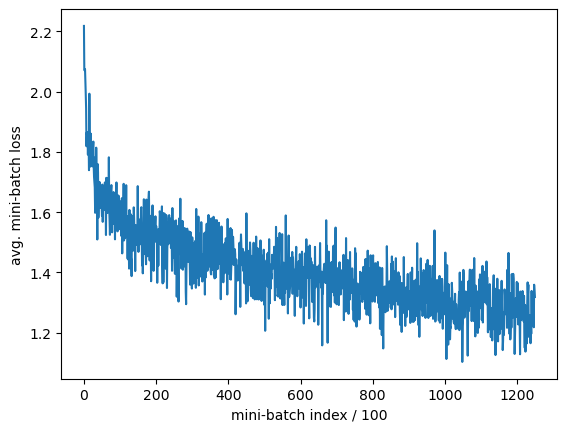

In [8]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [9]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [10]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 50 %
Accuracy of   car : 79 %
Accuracy of  bird : 50 %
Accuracy of   cat : 28 %
Accuracy of  deer : 40 %
Accuracy of   dog : 73 %
Accuracy of  frog : 59 %
Accuracy of horse : 63 %
Accuracy of  ship : 64 %
Accuracy of truck : 49 %


# Average Pooling + ReLU

In [15]:
model = models.resnet18(pretrained=True)
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.maxpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device) 
print(device) 

cuda:0


In [17]:
# Use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# Use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

In [18]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            #print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                #epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0


print('Finished Training.')

Finished Training.


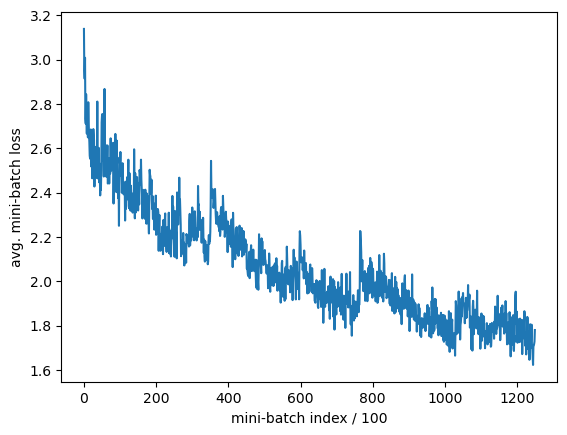

In [19]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [20]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 36 %


In [21]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 38 %
Accuracy of   car : 43 %
Accuracy of  bird : 24 %
Accuracy of   cat :  8 %
Accuracy of  deer :  6 %
Accuracy of   dog : 35 %
Accuracy of  frog : 56 %
Accuracy of horse : 41 %
Accuracy of  ship : 53 %
Accuracy of truck : 59 %


# Average Pooling + Sigmoid

In [3]:
model = models.resnet18(pretrained=True)
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.maxpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def replace_relu_with_sigmoid(model):
    for name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            setattr(model, name, nn.Sigmoid())  
        else:
            replace_relu_with_sigmoid(module)  

# Apply the replacement
replace_relu_with_sigmoid(model)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device) 
print(device) 

cuda:0


In [6]:
# Use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# Use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

In [7]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            if i % 1000 == 1000 - 1:
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                    epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0


print('Finished Training.')

[epoch: 0, i:   999] avg mini-batch loss: 4.530
[epoch: 0, i:  1999] avg mini-batch loss: 3.470
[epoch: 0, i:  2999] avg mini-batch loss: 4.025
[epoch: 0, i:  3999] avg mini-batch loss: 3.292
[epoch: 0, i:  4999] avg mini-batch loss: 3.434
[epoch: 0, i:  5999] avg mini-batch loss: 3.190
[epoch: 0, i:  6999] avg mini-batch loss: 3.258
[epoch: 0, i:  7999] avg mini-batch loss: 3.923
[epoch: 0, i:  8999] avg mini-batch loss: 2.979
[epoch: 0, i:  9999] avg mini-batch loss: 3.081
[epoch: 0, i: 10999] avg mini-batch loss: 3.509
[epoch: 0, i: 11999] avg mini-batch loss: 3.037
[epoch: 1, i:   999] avg mini-batch loss: 3.106
[epoch: 1, i:  1999] avg mini-batch loss: 3.087
[epoch: 1, i:  2999] avg mini-batch loss: 3.524
[epoch: 1, i:  3999] avg mini-batch loss: 3.091
[epoch: 1, i:  4999] avg mini-batch loss: 3.202
[epoch: 1, i:  5999] avg mini-batch loss: 3.274
[epoch: 1, i:  6999] avg mini-batch loss: 3.049
[epoch: 1, i:  7999] avg mini-batch loss: 3.186
[epoch: 1, i:  8999] avg mini-batch loss

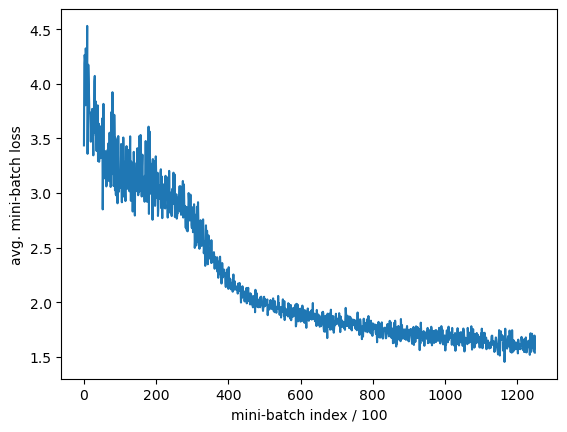

In [8]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [9]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 43 %


In [10]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 45 %
Accuracy of   car : 49 %
Accuracy of  bird : 28 %
Accuracy of   cat : 22 %
Accuracy of  deer : 21 %
Accuracy of   dog : 39 %
Accuracy of  frog : 60 %
Accuracy of horse : 49 %
Accuracy of  ship : 66 %
Accuracy of truck : 50 %


# Default Pooling + ReLU

In [11]:
model = models.resnet18(pretrained=True)
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device) 
print(device) 
# Use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# Use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

cuda:0


In [13]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            #print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
               # epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0


print('Finished Training.')

Finished Training.


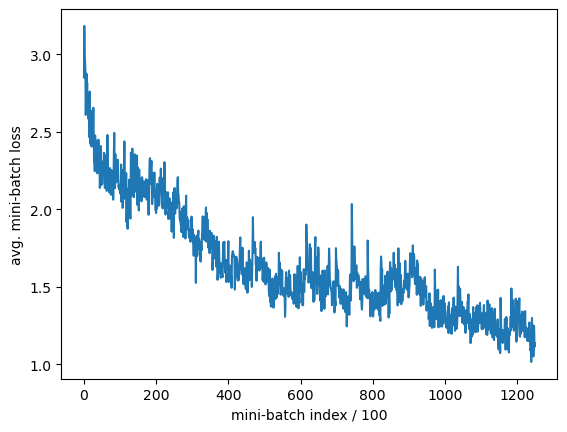

In [14]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [15]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [16]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 53 %
Accuracy of   car : 75 %
Accuracy of  bird : 43 %
Accuracy of   cat : 38 %
Accuracy of  deer : 62 %
Accuracy of   dog : 41 %
Accuracy of  frog : 74 %
Accuracy of horse : 72 %
Accuracy of  ship : 62 %
Accuracy of truck : 72 %
